# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

# ETL & EDA

In [102]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  
from xgboost import XGBClassifier
from bs4 import BeautifulSoup
from fuzzywuzzy import process

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

# Regular Season Data

In [103]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

All the dtypes look correct, so lets move on to our analysis

In [104]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [105]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [106]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

We can look at other factors as well:

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

# Tournament Data

In [107]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,1274,88,1400,81,N,0,29,49,...,25,11,15,9,14,20,13,6,1,23
1311,2023,146,1361,57,1166,56,N,0,25,66,...,17,10,11,8,24,9,9,3,2,11
1312,2023,152,1163,72,1274,59,N,0,28,57,...,20,12,12,12,17,10,9,8,1,12
1313,2023,152,1361,72,1194,71,N,0,25,57,...,22,16,21,7,24,6,9,6,2,17


In [108]:
#Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [109]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [110]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [111]:
detailed_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333


In [112]:
MSlotsData = 'MNCAATourneySlots.csv'
Mslots =  pd.read_csv(MSlotsData)
Mslots

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12
...,...,...,...,...
2447,2023,R6CH,R5WX,R5YZ
2448,2023,W16,W16a,W16b
2449,2023,X16,X16a,X16b
2450,2023,Y11,Y11a,Y11b


In [113]:
def build_slots(gender):
    slots = Mslots
    year = np.max(slots['Season'])
    
    slots = slots[slots['Season'] == year]
    slots = slots[slots['Slot'].str.contains('R')] 

    return slots

In [114]:
slots_m = build_slots('M')
#slots_w = build_slots('W')

display(slots_m)
#display(slots_w)

,Season,Slot,StrongSeed,WeakSeed
2385,2023,R1W1,W01,W16
2386,2023,R1W2,W02,W15
2387,2023,R1W3,W03,W14
2388,2023,R1W4,W04,W13
2389,2023,R1W5,W05,W12
...,...,...,...,...
2443,2023,R4Y1,R3Y1,R3Y2
2444,2023,R4Z1,R3Z1,R3Z2
2445,2023,R5WX,R4W1,R4X1
2446,2023,R5YZ,R4Y1,R4Z1


# Merge with MTeams.csv to get TeamName

In [115]:
# mteams_df = pd.read_csv('MTeams.csv')

# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
# merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
# merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_names = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_names

In [116]:
# Load the MTeams.csv file
mteams_df = pd.read_csv('MTeams.csv')

# Assuming detailed_tourney_results is your dataframe containing data about the tournament results
# and you have columns WTeamID and LTeamID in detailed_tourney_results

# Merge for WTeamID
merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_names = pd.concat([merged_df_winning, merged_df_losing[['TeamName2']]], axis=1)


# Display the resulting DataFrame
merged_df_names


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,TeamID,TeamName1,FirstD1Season,LastD1Season,TeamName2
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.432836,0.387097,0.451613,47,0.361702,1421,UNC Asheville,1987,2024,TX Southern
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.312500,0.250000,1.000000,44,0.181818,1112,Arizona,1985,2024,Vermont
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.362319,0.250000,0.666667,47,0.425532,1113,Arizona St,1985,2024,Memphis
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.450000,0.411765,0.705882,34,0.411765,1141,C Michigan,1985,2024,Creighton
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.446429,0.428571,0.750000,30,0.333333,1143,California,1985,2024,NC State
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,1274,88,1400,81,N,0,29,49,...,0.500000,0.400000,0.733333,28,0.321429,1274,Miami FL,1986,2024,Texas
1311,2023,146,1361,57,1166,56,N,0,25,66,...,0.400000,0.117647,0.909091,31,0.258065,1361,San Diego St,1985,2024,Creighton
1312,2023,152,1163,72,1274,59,N,0,28,57,...,0.322581,0.350000,1.000000,39,0.307692,1163,Connecticut,1985,2024,Miami FL
1313,2023,152,1361,72,1194,71,N,0,25,57,...,0.442308,0.409091,0.761905,30,0.233333,1361,San Diego St,1985,2024,FL Atlantic


# Merge with MNCAATourneySeeds.csv to get seeds of each team

In [117]:
# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_winning.rename(columns={'Seed': 'WTeamSeed'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_losing.rename(columns={'Seed': 'LTeamSeed'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_seeds

In [118]:
# Load the seeds dataframe
seeds_df = pd.read_csv('MNCAATourneySeeds.csv')
seeds_df['Seed_correct'] = seeds_df['Seed'].str.extract('(\d+)', expand=False).astype(int)

seeds_df = seeds_df[seeds_df['Season'] == 2023].copy()

seeds_df

,Season,Seed,TeamID,Seed_correct
2422,2023,W01,1345,1
2423,2023,W02,1266,2
2424,2023,W03,1243,3
2425,2023,W04,1397,4
2426,2023,W05,1181,5
...,...,...,...,...
2485,2023,Z12,1433,12
2486,2023,Z13,1233,13
2487,2023,Z14,1213,14
2488,2023,Z15,1421,15


In [119]:
unique_team_ids_count = seeds_df['TeamID'].nunique()
print("Count of unique TeamID values:", unique_team_ids_count)

Count of unique TeamID values: 68


In [120]:
seed_dict = seeds_df.set_index('Seed')['TeamID'].to_dict()

inverted_seed_dict = {value: key for key, value in seed_dict.items()}
inverted_seed_dict
#seed_dict

{1345: 'W01',
 1266: 'W02',
 1243: 'W03',
 1397: 'W04',
 1181: 'W05',
 1246: 'W06',
 1277: 'W07',
 1272: 'W08',
 1194: 'W09',
 1425: 'W10',
 1344: 'W11',
 1331: 'W12',
 1418: 'W13',
 1286: 'W14',
 1436: 'W15',
 1192: 'W16a',
 1411: 'W16b',
 1104: 'X01',
 1112: 'X02',
 1124: 'X03',
 1438: 'X04',
 1361: 'X05',
 1166: 'X06',
 1281: 'X07',
 1268: 'X08',
 1452: 'X09',
 1429: 'X10',
 1301: 'X11',
 1158: 'X12',
 1202: 'X13',
 1364: 'X14',
 1343: 'X15',
 1369: 'X16a',
 1394: 'X16b',
 1222: 'Y01',
 1400: 'Y02',
 1462: 'Y03',
 1231: 'Y04',
 1274: 'Y05',
 1235: 'Y06',
 1401: 'Y07',
 1234: 'Y08',
 1120: 'Y09',
 1336: 'Y10',
 1280: 'Y11a',
 1338: 'Y11b',
 1179: 'Y12',
 1245: 'Y13',
 1244: 'Y14',
 1159: 'Y15',
 1297: 'Y16',
 1242: 'Z01',
 1417: 'Z02',
 1211: 'Z03',
 1163: 'Z04',
 1388: 'Z05',
 1395: 'Z06',
 1321: 'Z07',
 1116: 'Z08',
 1228: 'Z09',
 1129: 'Z10',
 1113: 'Z11a',
 1305: 'Z11b',
 1433: 'Z12',
 1233: 'Z13',
 1213: 'Z14',
 1421: 'Z15',
 1224: 'Z16'}

In [143]:

# # Assuming merged_df_names is your already merged dataframe containing team names
# # seeds_df is your dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in merged_df_names

# # Merge for WTeamID
# merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_winning.rename(columns={'Seed_correct': 'WTeamSeedCorr'}, inplace=True)


# # Merge for LTeamID
# merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_losing.rename(columns={'Seed_correct': 'LTeamSeedCorr'}, inplace=True)

# # Combine the two merged dataframes horizontally
# merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing[['LTeamSeedCorr']]], axis=1)

# # Drop unnecessary columns from the losing team dataframe
# #merged_df_seeds.drop(['TeamID', 'TeamName'], axis=1, inplace=True)

# # Display the resulting DataFrame
# merged_df_seeds


In [144]:
# Merge for WTeamID
merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_winning.rename(columns={'Seed_correct': 'WTeamSeedCorr', 'Seed': 'WTeamSeed'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_losing.rename(columns={'Seed_correct': 'LTeamSeedCorr', 'Seed': 'LTeamSeed'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing[['LTeamSeedCorr', 'LTeamSeed']]], axis=1)

# Drop unnecessary columns from the losing team dataframe
#merged_df_seeds.drop(['TeamID', 'TeamName'], axis=1, inplace=True)

# Display the resulting DataFrame
merged_df_seeds


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,TeamID_x,TeamName1,FirstD1Season,LastD1Season,TeamName2,WTeamSeed,TeamID_y,WTeamSeedCorr,LTeamSeedCorr,LTeamSeed
0,2003,134,1421,92,1411,84,N,1,32,69,...,1421,UNC Asheville,1987,2024,TX Southern,NaN,NaN,NaN,NaN,NaN
1,2003,136,1112,80,1436,51,N,0,31,66,...,1112,Arizona,1985,2024,Vermont,NaN,NaN,NaN,NaN,NaN
2,2003,136,1113,84,1272,71,N,0,31,59,...,1113,Arizona St,1985,2024,Memphis,NaN,NaN,NaN,NaN,NaN
3,2003,136,1141,79,1166,73,N,0,29,53,...,1141,C Michigan,1985,2024,Creighton,NaN,NaN,NaN,NaN,NaN
4,2003,136,1143,76,1301,74,N,1,27,64,...,1143,California,1985,2024,NC State,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,1274,88,1400,81,N,0,29,49,...,1274,Miami FL,1986,2024,Texas,Y05,1274.0,5.0,2.0,Y02
1311,2023,146,1361,57,1166,56,N,0,25,66,...,1361,San Diego St,1985,2024,Creighton,X05,1361.0,5.0,6.0,X06
1312,2023,152,1163,72,1274,59,N,0,28,57,...,1163,Connecticut,1985,2024,Miami FL,Z04,1163.0,4.0,5.0,Y05
1313,2023,152,1361,72,1194,71,N,0,25,57,...,1361,San Diego St,1985,2024,FL Atlantic,X05,1361.0,5.0,9.0,W09


In [145]:
merged_df_seeds.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'WTeamSeed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', 'LTeamSeed'],
      dtype='object')

# Clean Data

In [148]:
def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['TeamID_x', 'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'TeamID_y'], inplace=True)

    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                 'WTeamSeedCorr', 'LTeamSeedCorr', 'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
                 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'WTeamSeed', 'LTeamSeed']]

    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['Outcome'] = (output['PointDiff'] > 0).astype(int)

    return output

#['W_Unnamed: 0' 'W_Season' 'WTeamName' 'L_Unnamed: 0' 'L_Season']

In [149]:
#tournament_data = prepare_data(detailed_tourney_results)
tournament_data = prepare_data(merged_df_seeds)

In [150]:
tournament_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_3PCT,T2_FTPCT,T2_ORBCHANCE,T2_ORPCT,T1_TeamSeed,T1_TeamSeedCorr,T2_TeamSeedCorr,T2_TeamSeed,PointDiff,Outcome
0,2003,134,1421,92,1411,84,0,1,32,69,...,0.387097,0.451613,47,0.361702,NaN,NaN,NaN,NaN,8,1
1,2003,136,1112,80,1436,51,0,0,31,66,...,0.250000,1.000000,44,0.181818,NaN,NaN,NaN,NaN,29,1
2,2003,136,1113,84,1272,71,0,0,31,59,...,0.250000,0.666667,47,0.425532,NaN,NaN,NaN,NaN,13,1
3,2003,136,1141,79,1166,73,0,0,29,53,...,0.411765,0.705882,34,0.411765,NaN,NaN,NaN,NaN,6,1
4,2003,136,1143,76,1301,74,0,1,27,64,...,0.428571,0.750000,30,0.333333,NaN,NaN,NaN,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,2023,146,1400,81,1274,88,0,0,30,60,...,0.250000,0.875000,18,0.222222,Y02,2.0,5.0,Y05,-7,0
2626,2023,146,1166,56,1361,57,0,0,22,55,...,0.230769,0.666667,36,0.333333,X06,6.0,5.0,X05,-1,0
2627,2023,152,1274,59,1163,72,0,0,20,62,...,0.346154,0.538462,30,0.433333,Y05,5.0,4.0,Z04,-13,0
2628,2023,152,1194,71,1361,72,0,0,23,52,...,0.500000,0.590909,36,0.333333,W09,9.0,5.0,X05,-1,0


In [151]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeed', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr',
       'T2_TeamSeed', 'PointDiff', 'Outcome'],
      dtype='object')

# Get Average amounts

In [152]:
# Choose the features that you want
# boxscore_cols = ['T1_Score', 'T2_Score',
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
#         'PointDiff','T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
#        'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
#        'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'T1__adj_o',
#        'T1__adj_d', 'T1__adj_tempo', 'T1__luck', 'T1__sos_adj_o',
#        'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d', 'T2__adj_tempo', 'T2__luck',
#        'T2__sos_adj_o', 'T2__sos_adj_d']

# boxscore_cols = ['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
#        'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
#        'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
#        'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
#        'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
#        'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
#        'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
#        'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', '3 Stars_1',
#        '4 Stars_1', '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2',
#        '5 Stars_2', 'Total Stars_2', 'T1__adj_o', 'T1__adj_d', 'T1__adj_tempo',
#        'T1__luck', 'T1__sos_adj_o', 'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d',
#        'T2__adj_tempo', 'T2__luck', 'T2__sos_adj_o', 'T2__sos_adj_d',
#        'PointDiff', 'Outcome']


boxscore_cols = ['T1_Score', 'T2_Score',
        'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'PointDiff',
       'Outcome']




In [153]:
# Get season averages by team and yearb
funcs = [np.mean]
season_statistics = tournament_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,NumOTmean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,...,T1_ORPCTmean,T2_FGPCTmean,T2_3PCTmean,T2_FTPCTmean,T2_ORBCHANCEmean,T2_ORPCTmean,T1_TeamSeedCorrmean,T2_TeamSeedCorrmean,PointDiffmean,Outcomemean
0,2003,1104,62.000000,67.000000,0.000000,22.000000,52.000000,5.000000,12.000000,13.000000,...,0.290323,0.387755,0.388889,0.846154,33.000000,0.393939,NaN,NaN,-5.000000,0.000000
1,2003,1112,84.750000,73.750000,0.500000,31.000000,67.750000,7.750000,20.750000,15.000000,...,0.343024,0.402656,0.339785,0.759921,42.250000,0.283499,NaN,NaN,11.000000,0.750000
2,2003,1113,80.000000,89.500000,0.000000,29.500000,64.000000,5.000000,14.500000,16.000000,...,0.345139,0.520142,0.402778,0.671569,36.500000,0.443535,NaN,NaN,-9.500000,0.500000
3,2003,1120,70.333333,68.000000,0.333333,25.333333,58.666667,7.000000,19.666667,12.666667,...,0.380952,0.393207,0.318323,0.810516,37.666667,0.371368,NaN,NaN,2.333333,0.666667
4,2003,1122,64.000000,86.000000,0.000000,24.000000,54.000000,2.000000,21.000000,14.000000,...,0.216216,0.500000,0.333333,0.615385,36.000000,0.416667,NaN,NaN,-22.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2023,1433,51.000000,63.000000,0.000000,18.000000,49.000000,5.000000,14.000000,10.000000,...,0.225806,0.408163,0.176471,0.740741,26.000000,0.346154,12.0,5.0,-12.000000,0.000000
1331,2023,1436,61.000000,78.000000,0.000000,23.000000,53.000000,8.000000,25.000000,7.000000,...,0.142857,0.517857,0.500000,0.666667,25.000000,0.200000,15.0,2.0,-17.000000,0.000000
1332,2023,1438,67.000000,68.000000,0.000000,24.000000,54.000000,2.000000,12.000000,17.000000,...,0.266667,0.392857,0.357143,0.736842,32.000000,0.156250,4.0,13.0,-1.000000,0.000000
1333,2023,1452,65.000000,67.000000,0.000000,22.000000,56.000000,8.000000,19.000000,13.000000,...,0.346154,0.511111,0.333333,0.681818,25.000000,0.320000,9.0,8.0,-2.000000,0.000000


In [154]:
season_statistics.columns

Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'NumOTmean',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_FTMmean',
       'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean', 'T1_TOmean',
       'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean', 'T2_ORmean',
       'T2_DRmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean',
       'T2_PFmean', 'SCOREDIFFmean', 'T1_FGPCTmean', 'T1_3PCTmean',
       'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean', 'T2_FGPCTmean',
       'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean', 'T2_ORPCTmean',
       'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean', 'PointDiffmean',
       'Outcomemean'],
      dtype='object')

In [155]:
tournament_data = pd.merge(tournament_data, season_statistics, on = ['Season', 'T1_TeamID'], how = 'left')

In [156]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeed', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr',
       'T2_TeamSeed', 'PointDiff', 'Outcome', 'T1_Scoremean', 'T2_Scoremean',
       'NumOTmean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T2_FGMmean',
       'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean',
       'T2_ORmean', 

In [157]:
# Calculate %FGM and %FGM3 for Team 1
tournament_data['T1_FG_PCT'] = (tournament_data['T1_FGMmean'] / tournament_data['T1_FGAmean']) * 100
tournament_data['T1_FGM3_PCT'] = (tournament_data['T1_FGM3mean'] / tournament_data['T1_FGA3mean']) * 100

# Calculate %FGM and %FGM3 for Team 2
tournament_data['T2_FG_PCT'] = (tournament_data['T2_FGMmean'] / tournament_data['T2_FGAmean']) * 100
tournament_data['T2_FGM3_PCT'] = (tournament_data['T2_FGM3mean'] / tournament_data['T2_FGA3mean']) * 100


In [158]:
# Convert DataFrame's columns to a list
columns_list = tournament_data.columns.tolist()

# Print the list of columns to display all columns
print(columns_list)


['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score', 'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE', 'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE', 'T2_ORPCT', 'T1_TeamSeed', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'T2_TeamSeed', 'PointDiff', 'Outcome', 'T1_Scoremean', 'T2_Scoremean', 'NumOTmean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean', 'T2_ORmean', 'T2_DRmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'T2_PFmean', 'SCOREDIFFmean',

In [159]:
tournament_data.iloc[0]

Season              2003
DayNum               134
T1_TeamID           1421
T1_Score              92
T2_TeamID           1411
                 ...    
Outcomemean          0.5
T1_FG_PCT      41.984733
T1_FGM3_PCT         32.0
T2_FG_PCT      46.511628
T2_FGM3_PCT    38.297872
Name: 0, Length: 99, dtype: object

In [160]:
row_dict = tournament_data.iloc[221].to_dict()
print(row_dict)
# T1 is winner 

{'Season': 2006, 'DayNum': 137, 'T1_TeamID': 1338, 'T1_Score': 79, 'T2_TeamID': 1245, 'T2_Score': 64, 'location': 0, 'NumOT': 0, 'T1_FGM': 31, 'T1_FGA': 46, 'T1_FGM3': 6, 'T1_FGA3': 14, 'T1_FTM': 11, 'T1_FTA': 15, 'T1_OR': 4, 'T1_DR': 24, 'T1_Ast': 18, 'T1_TO': 12, 'T1_Stl': 4, 'T1_Blk': 7, 'T1_PF': 13, 'T2_FGM': 23, 'T2_FGA': 59, 'T2_FGM3': 9, 'T2_FGA3': 22, 'T2_FTM': 9, 'T2_FTA': 13, 'T2_OR': 14, 'T2_DR': 15, 'T2_Ast': 12, 'T2_TO': 10, 'T2_Stl': 6, 'T2_Blk': 1, 'T2_PF': 19, 'SCOREDIFF': 15, 'T1_FGPCT': 0.6739130434782609, 'T1_3PCT': 0.42857142857142855, 'T1_FTPCT': 0.7333333333333333, 'T1_ORBCHANCE': 19, 'T1_ORPCT': 0.21052631578947367, 'T2_FGPCT': 0.3898305084745763, 'T2_3PCT': 0.4090909090909091, 'T2_FTPCT': 0.6923076923076923, 'T2_ORBCHANCE': 38, 'T2_ORPCT': 0.3684210526315789, 'T1_TeamSeed': nan, 'T1_TeamSeedCorr': nan, 'T2_TeamSeedCorr': nan, 'T2_TeamSeed': nan, 'PointDiff': 15, 'Outcome': 1, 'T1_Scoremean': 72.5, 'T2_Scoremean': 68.0, 'NumOTmean': 0.0, 'T1_FGMmean': 28.0, 'T1_F

# XGBoost RUN 1

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()


# Select the features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5399239543726235


In [162]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

ValueError: feature_names mismatch: ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean', 'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean', 'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean', 'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean'] ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']
expected T2_Astmean, T2_ORBCHANCEmean, T2_FGMmean, T1_FGM3mean, T1_TOmean, T2_3PCTmean, T1_ORBCHANCEmean, T2_FGAmean, T1_ORmean, T1_Stlmean, T1_FGMmean, T1_ORPCTmean, T2_FGA3mean, T1_PFmean, T2_ORmean, T1_3PCTmean, T2_FGPCTmean, T1_TeamSeedCorrmean, PointDiffmean, T1_FTPCTmean, T1_Astmean, T1_FGPCTmean, T2_TeamSeedCorrmean, T2_Stlmean, T2_Blkmean, T2_ORPCTmean, T2_FTPCTmean, T1_FGA3mean, T1_FGAmean, T2_TOmean, T2_FGM3mean in input data
training data did not have the following fields: T2_FGM3_PCT, T1_FGM3_PCT, T2_FG_PCT, T1_FG_PCT

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

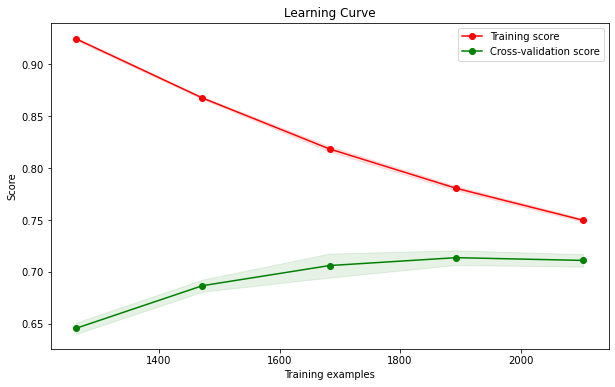

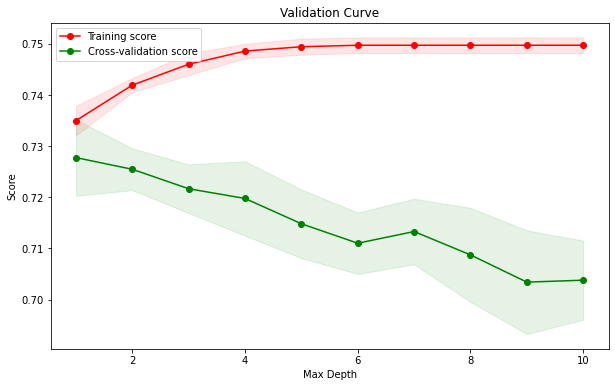

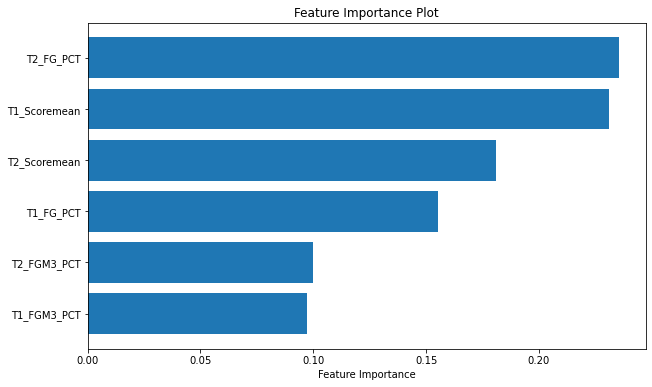

NameError: name 'XGBRegressor' is not defined

In [163]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Validation Curve
param_range = np.arange(1, 11)
train_scores, valid_scores = validation_curve(model, X, y, param_name="max_depth", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

# Feature Importance Plot
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

# Residual Plot (if regression)
if isinstance(model, XGBRegressor):
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()


# XGBoost RUN 2

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load your dataframe
df = tournament_data.copy()

# Add additional features if needed
# For example, you can add interactions between features, polynomial features, or other derived features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 
                     'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 
                     'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 
                     'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean','T1_FG_PCT',
                     'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', '5 Stars_2mean', '5 Stars_1mean']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


# XGBoost RUN 3

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeedCorr'] = label_encoder.fit_transform(df['T1_TeamSeedCorr'])
df['T2_TeamSeedCorr'] = label_encoder.fit_transform(df['T2_TeamSeedCorr'])


# Feature engineering: Add new features or transform existing ones
# For example, you can try adding interactions between features or polynomial features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', 'PointDiffmean', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Improved Accuracy:", accuracy)


In [ ]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


In [ ]:
tournament_data.columns

# Run 4

In [166]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeedCorr'] = label_encoder.fit_transform(df['T1_TeamSeedCorr'])
df['T2_TeamSeedCorr'] = label_encoder.fit_transform(df['T2_TeamSeedCorr'])



# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean',
       'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean',
       'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean',
       'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean',
       'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean',
       'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7452471482889734


In [187]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeed', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr',
       'T2_TeamSeed', 'PointDiff', 'Outcome', 'T1_Scoremean', 'T2_Scoremean',
       'NumOTmean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T2_FGMmean',
       'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean',
       'T2_ORmean', 

In [167]:
# Make predictions on the test data
#y_pred = best_model.predict(X_test)

# Convert the predicted values to a DataFrame
predictions_df = pd.DataFrame({'Actual_Outcome': y_test, 'Predicted_Outcome': y_pred})

# Display the predictions
print(predictions_df)

      Actual_Outcome  Predicted_Outcome
221                1                  1
318                1                  1
926                1                  0
2490               0                  1
1420               0                  1
...              ...                ...
76                 1                  1
2582               0                  0
620                1                  1
1151               1                  1
1220               1                  1

[526 rows x 2 columns]


In [168]:
# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)


Brier Score: 0.19234389150345468


If the model predicts 1, we predict T1 will win (so use the seed associated with T1 id in last column of submission).

In [169]:
# Assuming seed_dict is a dictionary in the format 'seed': teamID
# Assuming the model predictions are stored in a NumPy array called 'y_pred'

# Convert the NumPy array to a Pandas Series
y_pred_series = pd.Series(y_pred)

# Create a DataFrame with the desired columns
submission_df = pd.DataFrame(columns=['Tournament', 'Bracket', 'Slot', 'Team'])

# Set the values for 'Tournament' and 'Bracket' columns
submission_df['Tournament'] = 'M'
submission_df['Bracket'] = 1

# Copy the 'Slot' column from slots_m
submission_df['Slot'] = slots_m['Slot'].copy()

# Fill in the 'Team' column based on model predictions and seed_dict
submission_df['Team'] = y_pred_series.map(seed_dict)

# Display the submission DataFrame
print(submission_df)


     Tournament  Bracket  Slot  Team
2385        NaN      NaN  R1W1   NaN
2386        NaN      NaN  R1W2   NaN
2387        NaN      NaN  R1W3   NaN
2388        NaN      NaN  R1W4   NaN
2389        NaN      NaN  R1W5   NaN
...         ...      ...   ...   ...
2443        NaN      NaN  R4Y1   NaN
2444        NaN      NaN  R4Z1   NaN
2445        NaN      NaN  R5WX   NaN
2446        NaN      NaN  R5YZ   NaN
2447        NaN      NaN  R6CH   NaN

[63 rows x 4 columns]


In [170]:
slots_m

,Season,Slot,StrongSeed,WeakSeed
2385,2023,R1W1,W01,W16
2386,2023,R1W2,W02,W15
2387,2023,R1W3,W03,W14
2388,2023,R1W4,W04,W13
2389,2023,R1W5,W05,W12
...,...,...,...,...
2443,2023,R4Y1,R3Y1,R3Y2
2444,2023,R4Z1,R3Z1,R3Z2
2445,2023,R5WX,R4W1,R4X1
2446,2023,R5YZ,R4Y1,R4Z1


In [171]:
slots_m['Slot']

2385    R1W1
2386    R1W2
2387    R1W3
2388    R1W4
2389    R1W5
        ... 
2443    R4Y1
2444    R4Z1
2445    R5WX
2446    R5YZ
2447    R6CH
Name: Slot, Length: 63, dtype: object

In [172]:
import pandas as pd

# Create a DataFrame for submission
submission_df = pd.DataFrame(columns=['RowId', 'Tournament', 'Bracket', 'Slot', 'Team'])

# Add data to the submission DataFrame
submission_df['RowId'] = range(1, len(y_pred) + 1)  # Dummy enumeration of rows
submission_df['Tournament'] = 'M'  # Assuming Men's tournament
submission_df['Bracket'] = 1  # Bracket enumeration
# Reset the index of slots_m['Slot'] to ignore the index
slots_m_reset = slots_m['Slot'].reset_index(drop=True)

# Copy the reset index Slot column from slots_m DataFrame
submission_df['Slot'] = slots_m_reset.copy()

# Fill in the 'Team' column based on model predictions
for i, pred in enumerate(y_pred):
    if pred == 1:
        team_id = df.iloc[i]['T1_TeamID']
    else:
        team_id = df.iloc[i]['T2_TeamID']
    
    # Look up the seed associated with the team ID in seed_dict
    seed = inverted_seed_dict.get(team_id, 'N/A')
    submission_df.loc[i, 'Team'] = seed

# Save the submission DataFrame to a CSV file
#submission_df.to_csv('submission.csv', index=False)
print(submission_df)

     RowId Tournament  Bracket  Slot  Team
0        1          M        1  R1W1   Z15
1        2          M        1  R1W2   X02
2        3          M        1  R1W3   W08
3        4          M        1  R1W4   N/A
4        5          M        1  R1W5   N/A
..     ...        ...      ...   ...   ...
521    522          M        1   NaN   Z03
522    523          M        1   NaN   X10
523    524          M        1   NaN   W06
524    525          M        1   NaN   N/A
525    526          M        1   NaN  Y11b

[526 rows x 5 columns]


In [173]:
#print(submission_df.head(64))
#rows 0-62: R1W1 - R6CH

In [233]:
#DUMMY VALUES BUT A STARTING POINT

import pandas as pd

def generate_submission_df(model, X_data, n_brackets):
    """
    Generate a submission DataFrame based on multiple model runs.

    Parameters:
    - model: Your trained model.
    - X_data: DataFrame containing the features for prediction.
    - n_brackets (int): Number of brackets to simulate.

    Returns:
    - pd.DataFrame: Submission DataFrame in the specified format.
    """
    submission_df = pd.DataFrame(columns=['RowId', 'Tournament', 'Bracket', 'Slot', 'Team'])
    row_id = 1  # Initialize RowId

    for bracket in range(1, n_brackets + 1):
        # Make predictions with the model
        y_pred = model.predict(X_data)

        # Create a DataFrame for this bracket's predictions
        bracket_df = pd.DataFrame({
            'RowId': range(row_id, row_id + len(y_pred)),
            'Tournament': 'M',  # Assuming Men's tournament
            'Bracket': bracket,
            'Slot': range(1, len(y_pred) + 1),  # Dummy Slot numbering
            'Team': y_pred
        })

        # Increment RowId for the next bracket
        row_id += len(y_pred)

        # Append the bracket's DataFrame to the submission DataFrame
        submission_df = pd.concat([submission_df, bracket_df], ignore_index=True)

    return submission_df


In [234]:
X_test.columns

Index(['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean',
       'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean',
       'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean', 'T1_3PCTmean',
       'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean', 'T2_FGPCTmean',
       'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean', 'T2_ORPCTmean',
       'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean'],
      dtype='object')

In [235]:
# Assuming you have a trained model 'best_model' and feature data 'X_test'
n_brackets = 10#0000  # Number of brackets to simulate

# Generate the submission DataFrame
submission_df = generate_submission_df(best_model, X_test, n_brackets)

# Save the submission DataFrame to a CSV file
#submission_df.to_csv('submission.csv', index=False)


print(submission_df)

     RowId Tournament Bracket Slot Team
0        1          M       1    1    1
1        2          M       1    2    1
2        3          M       1    3    0
3        4          M       1    4    1
4        5          M       1    5    1
...    ...        ...     ...  ...  ...
5255  5256          M      10  522    1
5256  5257          M      10  523    0
5257  5258          M      10  524    1
5258  5259          M      10  525    1
5259  5260          M      10  526    1

[5260 rows x 5 columns]
